<a href="https://colab.research.google.com/github/Ashutosh1001/Style-transfer/blob/master/Major_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [ ]:
# keeping only the features part, dont need the classifier part
vgg = models.vgg19(pretrained=True).features

# freezing all the layers
for param in vgg.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 59.1MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
#Image x-y dims should be less than 400
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')
  
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
    
  if shape is not None:
    size = shape

  in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
  #################
  ## discarding the transparent, alpha channel (that's the :3)
  ## and add the batch dimension
  #################
  image = in_transform(image)[:3,:,:].unsqueeze(0)
    
  return image

In [ ]:
# load in content and style image
content = load_image('content.jpg').to(device)
# Resize style to match content, to simplify the code
style = load_image('Van_gogh.jpg', shape=content.shape[-2:]).to(device)

In [ ]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

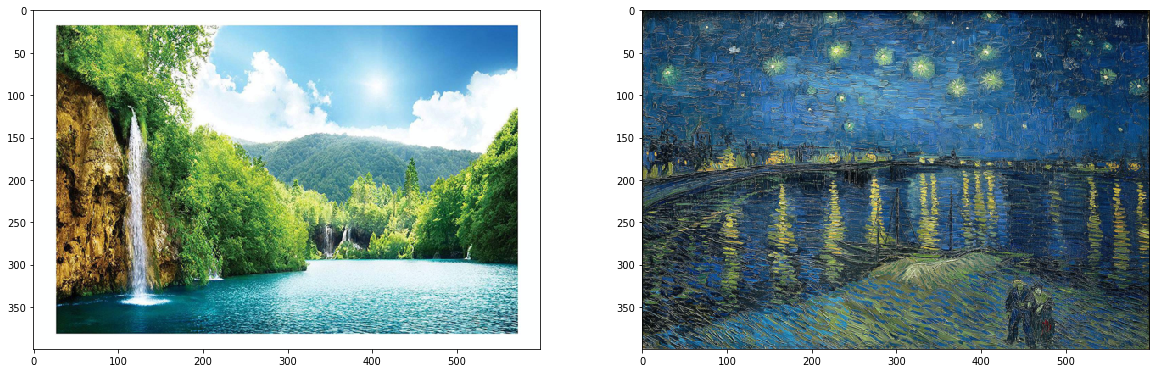

In [ ]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [ ]:
## Getting the features

def get_features(image, model, layers=None):
    
    if layers is None:
      layers = {'0': 'conv1_1',
                '5': 'conv2_1',
                '10': 'conv3_1',
                '19': 'conv4_1',
                '21': 'conv4_2',
                '28': 'conv5_1'}
        
    features = {}
    x = image
    
    for name, layer in model._modules.items():
      x = layer(x)
      if name in layers:
        features[layers[name]] = x
    
    return features    

In [ ]:
## Getting the gram matrix

def gram_matrix(tensor):
  ## getting the batch_size, depth, height, and width of the Tensor
  _, d, h, w = tensor.size()
  ## reshape it, so we're multiplying the features for each channel
  tensor = tensor.view(d, h * w)
  ## calculate the gram matrix
  gram = torch.mm(tensor, tensor.t())
  return gram

In [ ]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
target = content.clone().requires_grad_(True).to(device)

In [ ]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

# Excluded `conv4_2` our content representation

content_weight = 1  # alpha
style_weight = 1e6  # beta

In [ ]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  

style_loss_ar = []
content_loss_ar = []
total_loss_ar = []

for ii in range(1, steps+1):
    
    ## Calculate the content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # iterating through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        #Calculating the target gram matrix
        target_gram = gram_matrix(target_feature)
        
        #Getting the "style" style representation
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    style_loss_ar.append(style_loss)
    content_loss_ar.append(content_loss)
    total_loss_ar.append(total_loss)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

KeyboardInterrupt: ignored

In [ ]:
def draw_result(loss1, title, color1):
   
    plt.plot(loss1, color1)

    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    #plt.savefig(title+".png")  # should before show method

    # show
    plt.show()


No handles with labels found to put in legend.


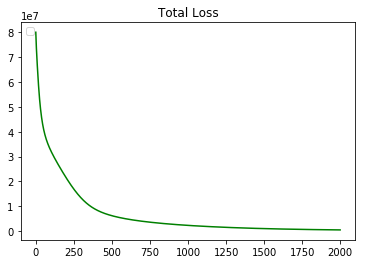

No handles with labels found to put in legend.


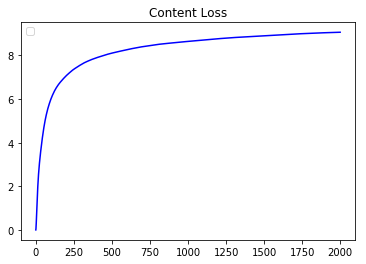

No handles with labels found to put in legend.


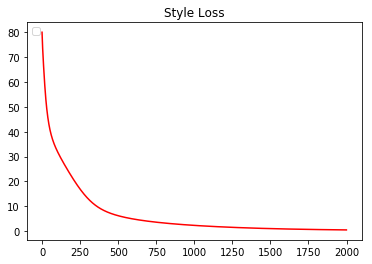

In [ ]:
draw_result(total_loss_ar, "Total Loss", '-g')
draw_result(content_loss_ar, "Content Loss", '-b')
draw_result(style_loss_ar, "Style Loss", '-r')